In [134]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from geopy.geocoders import Nominatim
from tqdm import tqdm
from geopy.distance import geodesic
import folium
from folium.plugins import MarkerCluster
import math
import datetime
import geopandas as gpd
import urllib.request
import requests
import json
import openmeteo_requests
import requests_cache
from shapely.geometry import Polygon, Point
from retry_requests import retry
from shapely.wkt import loads
import random 
from pathlib import Path

In [135]:
DATA_DIR_BOMEN = Path("src/data_bomen")
DATA_DIR_GEBOUWEN = Path("src/data_gebouwen")

INCIDENT_DATA_PATH = DATA_DIR_BOMEN / 'Incidenten_oorspronkelijk_volledig.csv'
BOUWJAAR_DATA_PATH = DATA_DIR_GEBOUWEN / 'BOUWJAAR.csv'
ZIPCODE_JSON_PATH = DATA_DIR_BOMEN / "zipcodes_boxes.json"
GRID_SIZE = 200     ## GRID SIZE IN METERS

BUILDING_DATA_CLEAN_PATH = DATA_DIR_GEBOUWEN / f"building_geo_data_clean_{str(GRID_SIZE)}.csv"
GRID_DATA_PATH = DATA_DIR_GEBOUWEN / f"grid_enriched_buildings_{GRID_SIZE}.csv"
INCIDENTS_WEATHER_PATH = DATA_DIR_GEBOUWEN / "Building_incident_with_weather_data.csv"
INCIDENTS_WEATHER_GEO_PATH = DATA_DIR_GEBOUWEN / f"incidents_weather_geo_buildings_{GRID_SIZE}.csv"

POSITIVE_SAMPLES_PATH = DATA_DIR_GEBOUWEN / f"positive_samples_buildings_{GRID_SIZE}.csv"
NEGATIVE_SAMPLES_PATH = DATA_DIR_GEBOUWEN / f"negative_samples_buildings_{GRID_SIZE}.csv"

ZIP_KEY = "Zipcode"
ZIP4_KEY = "Zip4"

DATE_WINDOW = 5

AMSTERDAM_BBOX = (52.26618, 4.64663, 52.475115999999994, 5.150491999999999)

# GRID PATH 200 by 200
GRIDS_200_AMSTERDAM_PATH = Path("src/final_data/grids/grids_200_amsterdam.csv")

In [164]:
BUILDING_COLUMNS = [
    "OBJECTNUMMER",
    "grid_id",
    "Bouwjaar",       
    "WKT_LNG_LAT",
    "WKT_LAT_LNG",
    "LNG",
    "LAT"
]

SERVICE_AREAS_OUT_OF_SCOPE = [
    "Amstelveen",
    "Aalsmeer",
    "Uithoorn"
]

INCIDENT_COLUMNS = [
    "Incident_ID",
    "Service_Area",
    "grid_id",
    "Date",
    "Hour",
    "temperature_2m",
    "relative_humidity_2m",
    "dew_point_2m",
    "apparent_temperature",
    "precipitation",
    "rain",
    "snowfall",
    "snow_depth",
    "weather_code",
    "pressure_msl",
    "surface_pressure",
    "wind_speed_10m",
    "wind_direction_10m",
    "wind_gusts_10m",
    "soil_temperature_0_to_7cm",
    "soil_temperature_7_to_28cm",
    "soil_temperature_28_to_100cm",
    "soil_temperature_100_to_255cm",
    "soil_moisture_0_to_7cm",
    "soil_moisture_7_to_28cm",
    "soil_moisture_28_to_100cm",
    "soil_moisture_100_to_255cm",
]

GRID_COLUMNS = [
    "grid_id",
    "has_building",
    "Gemiddeld Bouwjaar",
    "Gewogen Gemiddeld Bouwjaar",
    "Voor 1860",
    "1860-1919",
    "1920-1939",
    "1940-1969",
    "1970-1985",
    "1986-2001",
    "Na 2001"
]

BUILDING_COLUMNS_MODEL = [
    "building_id",
    "Bouwjaar",
    "bouwjaar_category",     
    "WKT_LNG_LAT",
    "WKT_LAT_LNG",
    "LNG",
    "LAT"
]

In [37]:
# def create_grid_gdf():
#     geolocator = Nominatim(user_agent="user_agent")

#     # Get coordinates for Amsterdam
#     location = geolocator.geocode("Amsterdam, Netherlands")
#     # amsterdam_lat, amsterdam_lon = location.latitude, location.longitude
#     amsterdam_lat, amsterdam_lon = [4.88, 52.32]

#     amsterdam_bbox = AMSTERDAM_BBOX

#     # Calculate grid bounds
#     lat_step = GRID_SIZE / 111000  # 1 degree of latitude is approximately 111 kilometers
#     lon_step = (GRID_SIZE / 111000) / np.cos(np.radians(amsterdam_lat))  # Correct for latitude

#     grid_polygons = []
#     for lat in np.arange(amsterdam_bbox[0], amsterdam_bbox[2], lat_step):
#         for lon in np.arange(amsterdam_bbox[1], amsterdam_bbox[3], lon_step):
#             polygon = Polygon([
#                 (lon, lat),
#                 (lon + lon_step, lat),
#                 (lon + lon_step, lat + lat_step),
#                 (lon, lat + lat_step),
#                 (lon, lat),
#             ])
#             grid_polygons.append(polygon)

#     grid_gdf = gpd.GeoDataFrame(geometry=grid_polygons, crs="EPSG:4326")
#     return grid_gdf

In [56]:
# def create_building_incident_gdf(incidents_weather_df, buildings, grid_gdf):
#     # Filter on areas in scope
#     incidents_weather_df = incidents_weather_df[~incidents_weather_df.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]

#     # create gdf from buildings
#     building_gdf = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(buildings['LNG'], buildings['LAT']), crs="EPSG:4326")
#     # create gdf from indicents
#     incident_gdf = gpd.GeoDataFrame(incidents_weather_df, geometry=gpd.points_from_xy(incidents_weather_df['LON'], incidents_weather_df['LAT']), crs="EPSG:4326")
#     #join with grid gdf
#     building_gdf = gpd.sjoin(building_gdf, grid_gdf, how="left", op="within")
#     incident_gdf = gpd.sjoin(incident_gdf, grid_gdf, how="left", op="within")

#     #clean up gdf
#     building_gdf = building_gdf.rename(columns={"index_right" : "grid_id", "geometry" : "location"})
#     incident_gdf = incident_gdf.rename(columns={"index_right" : "grid_id", "geometry" : "location"})

#     return building_gdf, incident_gdf

In [165]:
# GRIDS
grids = pd.read_csv(GRIDS_200_AMSTERDAM_PATH, sep=";", encoding="utf-8")
grids = gpd.GeoDataFrame(grids, geometry=gpd.GeoSeries.from_wkt(grids['geometry']))

# INCIDENTS
incidents = pd.read_csv(INCIDENT_DATA_PATH, sep=",", encoding="utf-8")
incidents = incidents.set_index('Incident_ID')

# BUILDINGS
buildings = pd.read_csv(BOUWJAAR_DATA_PATH, sep=";", encoding="utf-8")
buildings['WKT_LNG_LAT'] = buildings['WKT_LNG_LAT'].apply(loads)
buildings['WKT_LAT_LNG'] = buildings['WKT_LAT_LNG'].apply(loads)

# BUILDING INCIDENTS WITH WEATHER DATA
building_incidents_weather = pd.read_csv(INCIDENTS_WEATHER_PATH, sep=",", encoding="utf-8")
building_incidents_weather = building_incidents_weather[~building_incidents_weather.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]

# BUILDING INCIDENTS WITHOUT WEATHER DATA
building_incidents = incidents[incidents["Damage_Type"]=="Building"]
building_incidents = building_incidents[~building_incidents.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]

# GEODATAFRAME BUILDINGS
buildings_geo = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(buildings['LNG'], buildings['LAT']), crs="EPSG:4326")
incidents_geo = gpd.GeoDataFrame(building_incidents_weather, geometry=gpd.points_from_xy(building_incidents_weather['LON'], building_incidents_weather['LAT']), crs="EPSG:4326")

# MAP BUILDINGS AND INCIDENTS TO GRID IDS
buildings_geo = gpd.sjoin(buildings_geo, grids, how="left", op="within")
incidents_geo = gpd.sjoin(incidents_geo, grids, how="left", op="within")

buildings_geo = buildings_geo.rename(columns={"index_right" : "grid_id", "geometry" : "location"})
incidents_geo = incidents_geo.rename(columns={"index_right" : "grid_id", "geometry" : "location"})

# GET RID OF UNNECESSARY COLUMNS
buildings_geo = buildings_geo[BUILDING_COLUMNS]

def map_bouwjaar_to_category(bouwjaar):
    if bouwjaar < 1860:
        return "Voor 1860"
    elif 1860 <= bouwjaar <= 1919:
        return "1860-1919"
    elif 1920 <= bouwjaar <= 1939:
        return "1920-1939"
    elif 1940 <= bouwjaar <= 1969:
        return "1940-1969"
    elif 1970 <= bouwjaar <= 1985:
        return "1970-1985"
    elif 1986 <= bouwjaar <= 2001:
        return "1986-2001"
    else:
        return "Na 2001"

# BOUWJAAR CATEGORIE MAKEN
buildings_geo['bouwjaar_category'] = buildings_geo['Bouwjaar'].apply(map_bouwjaar_to_category)
buildings_geo['area'] = buildings_geo['WKT_LAT_LNG'].apply(lambda x: x.area)

# ENRICH 
for i in grids.index:
    buildings_geo_sub = buildings_geo[buildings_geo.grid_id == i]
    if len(buildings_geo_sub) > 0:
        grids.at[i, "Gemiddeld Bouwjaar"] = round(np.mean(buildings_geo_sub.Bouwjaar.values), 3)
        weighted_avg_bouwjaar = np.average(buildings_geo_sub.Bouwjaar, weights=buildings_geo_sub.area)
        grids.at[i, "Gewogen Gemiddeld Bouwjaar"] = round(weighted_avg_bouwjaar, 3)
        for name, count in buildings_geo_sub.bouwjaar_category.value_counts().items():
            grids.at[i, "has_building"] = True
            grids.at[i, name] = count
    else:
        grids.at[i, "has_building"] = False
grids.fillna(0, inplace=True)

# SAVE BUILDING AND INCIDENT DATA 
buildings_geo.to_csv(BUILDING_DATA_CLEAN_PATH, sep=",", encoding="utf-8", index=False)
incidents_geo.to_csv(INCIDENTS_WEATHER_GEO_PATH, sep=",", encoding="utf-8", index=False)

# CLEAN AND SAVE GRID DATA
grids = grids.fillna(0)
grids[grids.has_building == True]
grids['grid_id'] = grids.index
grids.to_csv(GRID_DATA_PATH, sep=",", encoding="utf-8", index=False)

# CREATE AND SAVE POSITIVE SAMPLES
incidents_geo.Date = pd.to_datetime(incidents_geo.Date)
incidents_geo_positive = incidents_geo[INCIDENT_COLUMNS]

grids['grid_id'] = grids.index
grids_positive = grids[GRID_COLUMNS]

buildings_geo = buildings_geo.rename(columns={"OBJECTNUMMER" : "building_id"})
buildings_geo_positive = buildings_geo[BUILDING_COLUMNS_MODEL]

positive_samples = grids_positive.merge(incidents_geo_positive, on='grid_id', how='inner')
positive_samples.to_csv(POSITIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)

# CREATE AND SAVE NEGATIVE SAMPLES WITHOUT WEATHER DATA
def verify_sample(incidents, grid_id, date, window=DATE_WINDOW):
    start_date = date - pd.DateOffset(days=window)
    end_date = date + pd.DateOffset(days=window)

    incidents['Date'] = pd.to_datetime(incidents['Date'])  # Convert 'Date' column to Timestamp

    grids = incidents[(incidents['Date'] >= start_date) & (incidents['Date'] <= end_date)].values
    return False if grid_id not in grids else True

grids_with_building = list(grids[grids.has_building == True].grid_id.values)
negatives = positive_samples[['Date', 'Hour']]
negatives[GRID_COLUMNS] = None

for i, row in negatives.iterrows():
    random_grid = random.sample(grids_with_building, 1)[0]
    while(verify_sample(incidents, random_grid, row.Date)):
        random_grid = random.sample(grids_with_building, 1)[0]
    grid_data = grids[grids.grid_id == random_grid][GRID_COLUMNS].reset_index(drop=True)
    negatives.loc[i, GRID_COLUMNS] = grid_data.iloc[0]

negatives.to_csv(NEGATIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)

C:\Users\Aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Aliha\AppData\Local\Temp\ipykernel_19776\1199553647.py:27: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  buildings_geo = gpd.sjoin(buildings_geo, grids, how="left", op="within")
C:\Users\Aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please

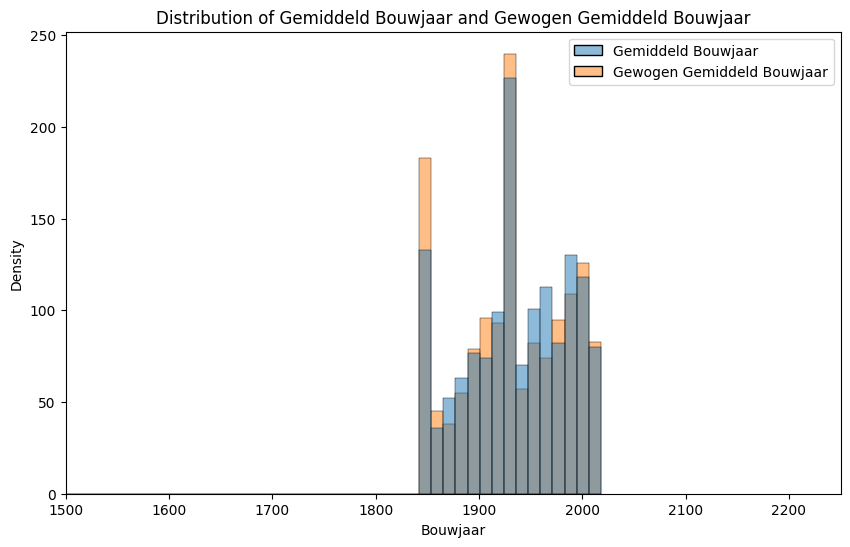

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named positive_samples
# Combine the two columns into a single DataFrame for plotting
plot_data = pd.DataFrame({
    'Gemiddeld Bouwjaar': positive_samples['Gemiddeld Bouwjaar'],
    'Gewogen Gemiddeld Bouwjaar': positive_samples['Gewogen Gemiddeld Bouwjaar']
})

# Create kernel density plots
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_data, fill=True)

# Set x-axis limits
plt.xlim(1500, 2250)

# Set labels and title
plt.xlabel('Bouwjaar')
plt.ylabel('Density')
plt.title('Distribution of Gemiddeld Bouwjaar and Gewogen Gemiddeld Bouwjaar')

# Show the plot
plt.show()



In [ ]:
# BACK UP CELL
# GRIDS
grids = pd.read_csv(GRIDS_200_AMSTERDAM_PATH, sep=";", encoding="utf-8")
grids = gpd.GeoDataFrame(grids, geometry=gpd.GeoSeries.from_wkt(grids['geometry']))

# INCIDENTS
incidents = pd.read_csv(INCIDENT_DATA_PATH, sep=",", encoding="utf-8")
incidents = incidents.set_index('Incident_ID')

# BUILDINGS
buildings = pd.read_csv(BOUWJAAR_DATA_PATH, sep=";", encoding="utf-8")
buildings['WKT_LNG_LAT'] = buildings['WKT_LNG_LAT'].apply(loads)
buildings['WKT_LAT_LNG'] = buildings['WKT_LAT_LNG'].apply(loads)

# BUILDING INCIDENTS WITH WEATHER DATA
building_incidents_weather = pd.read_csv(INCIDENTS_WEATHER_PATH, sep=",", encoding="utf-8")
building_incidents_weather = building_incidents_weather[~building_incidents_weather.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]

# BUILDING INCIDENTS WITHOUT WEATHER DATA
building_incidents = incidents[incidents["Damage_Type"]=="Building"]
building_incidents = building_incidents[~building_incidents.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]

# GEODATAFRAME BUILDINGS
buildings_geo = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(buildings['LNG'], buildings['LAT']), crs="EPSG:4326")
incidents_geo = gpd.GeoDataFrame(building_incidents_weather, geometry=gpd.points_from_xy(building_incidents_weather['LON'], building_incidents_weather['LAT']), crs="EPSG:4326")

# MAP BUILDINGS AND INCIDENTS TO GRID IDS
buildings_geo = gpd.sjoin(buildings_geo, grids, how="left", op="within")
incidents_geo = gpd.sjoin(incidents_geo, grids, how="left", op="within")

buildings_geo = buildings_geo.rename(columns={"index_right" : "grid_id", "geometry" : "location"})
incidents_geo = incidents_geo.rename(columns={"index_right" : "grid_id", "geometry" : "location"})

# GET RID OF UNNECESSARY COLUMNS
buildings_geo = buildings_geo[BUILDING_COLUMNS]

def map_bouwjaar_to_category(bouwjaar):
    if bouwjaar < 1860:
        return "Voor 1860"
    elif 1860 <= bouwjaar <= 1919:
        return "1860-1919"
    elif 1920 <= bouwjaar <= 1939:
        return "1920-1939"
    elif 1940 <= bouwjaar <= 1969:
        return "1940-1969"
    elif 1970 <= bouwjaar <= 1985:
        return "1970-1985"
    elif 1986 <= bouwjaar <= 2001:
        return "1986-2001"
    else:
        return "Na 2001"

# BOUWJAAR CATEGORIE MAKEN
buildings_geo['bouwjaar_category'] = buildings_geo['Bouwjaar'].apply(map_bouwjaar_to_category)
buildings_geo['area'] = buildings_geo['WKT_LAT_LNG'].apply(lambda x: x.area)

# ENRICH 
for i in grids.index:
    buildings_geo_sub = buildings_geo[buildings_geo.grid_id == i]
    if len(buildings_geo_sub) > 0:
        grids.at[i, "Gemiddeld Bouwjaar"] = round(np.mean(buildings_geo_sub.Bouwjaar.values), 3)
        weighted_avg_bouwjaar = np.average(buildings_geo_sub.Bouwjaar, weights=buildings_geo_sub.area)
        grids.at[i, "Gewogen Gemiddeld Bouwjaar"] = round(weighted_avg_bouwjaar, 3)
        for name, count in buildings_geo_sub.bouwjaar_category.value_counts().items():
            grids.at[i, "has_building"] = True
            grids.at[i, name] = count
    else:
        grids.at[i, "has_building"] = False
grids.fillna(0, inplace=True)

# SAVE BUILDING AND INCIDENT DATA 
buildings_geo.to_csv(BUILDING_DATA_CLEAN_PATH, sep=",", encoding="utf-8", index=False)
incidents_geo.to_csv(INCIDENTS_WEATHER_GEO_PATH, sep=",", encoding="utf-8", index=False)

# CLEAN AND SAVE GRID DATA
grids = grids.fillna(0)
grids[grids.has_building == True]
grids['grid_id'] = grids.index
grids.to_csv(GRID_DATA_PATH, sep=",", encoding="utf-8", index=False)

# CREATE AND SAVE POSITIVE SAMPLES
incidents_geo.Date = pd.to_datetime(incidents_geo.Date)
incidents_geo_positive = incidents_geo[INCIDENT_COLUMNS]

grids['grid_id'] = grids.index
grids_positive = grids[GRID_COLUMNS]

buildings_geo = buildings_geo.rename(columns={"OBJECTNUMMER" : "building_id"})
buildings_geo_positive = buildings_geo[BUILDING_COLUMNS_MODEL]

positive_samples = grids_positive.merge(incidents_geo_positive, on='grid_id', how='inner')
positive_samples.to_csv(POSITIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)

# CREATE AND SAVE NEGATIVE SAMPLES WITHOUT WEATHER DATA
def verify_sample(incidents, grid_id, date, window=DATE_WINDOW):
    start_date = date - pd.DateOffset(days=window)
    end_date = date + pd.DateOffset(days=window)

    incidents['Date'] = pd.to_datetime(incidents['Date'])  # Convert 'Date' column to Timestamp

    grids = incidents[(incidents['Date'] >= start_date) & (incidents['Date'] <= end_date)].values
    return False if grid_id not in grids else True

grids_with_building = list(grids[grids.has_building == True].grid_id.values)
negatives = positive_samples[['Date', 'Hour']]
negatives[GRID_COLUMNS] = None

for i, row in negatives.iterrows():
    random_grid = random.sample(grids_with_building, 1)[0]
    while(verify_sample(incidents, random_grid, row.Date)):
        random_grid = random.sample(grids_with_building, 1)[0]
    grid_data = grids[grids.grid_id == random_grid][GRID_COLUMNS].reset_index(drop=True)
    negatives.loc[i, GRID_COLUMNS] = grid_data.iloc[0]

negatives.to_csv(NEGATIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)

In [73]:
# def convert_cat_to_avg(
#     cat_values,
#     delimeter = "-"
# ):
#     ''' 
#     Converts categorical values to means of type float
#     Splits cat values on delimter, computes the mean for each cat
#     Returns mean of all means of the categories
#     '''
#     means = []
#     for cat in cat_values:
#         if not isinstance(cat, str):
#             continue
#         if not delimeter in cat:
#             continue
#         vals = cat.split(delimeter)
#         means.append(np.mean([float(val) for val in vals]))
#     m = round(np.mean(means), 3)
#     return 0 if np.isnan(m) else m

In [9]:
# def enrich_grid_df(
#     grid_gdf,
#     building_gdf
# ):
#     for i in grid_gdf.index:
#         building_sub_df = building_gdf[building_gdf.grid_id == i]
#         if len(building_sub_df)>0:
#             # Compute and add averages for height, diameter and year
#             grid_gdf.at[i, "Bouwjaar"] = round(np.mean(building_sub_df.Bouwjaar.values), 3)
#             # Add soortnaam counts
#             # for name, count in building_sub_df.soortnaamKort.value_counts().items():
#             #     grid_gdf.at[i, "has_building"] = True
#             #     grid_gdf.at[i, name] = count
#         else:
#             grid_gdf.at[i, "has_building"] = False

#     return grid_gdf, building_gdf

In [10]:
# def save_data(building_gdf, incident_gdf, grid_gdf):
#     # save data
#     building_gdf.to_csv(BUILDING_DATA_CLEAN_PATH, sep=",", encoding="utf-8", index=False)
#     incident_gdf.to_csv(INCIDENTS_WEATHER_GEO_PATH, sep=",", encoding="utf-8", index=False)

#     # clean and save data
#     grid_gdf = grid_gdf.fillna(0)
#     grid_gdf[grid_gdf.has_building == True]
#     grid_gdf['grid_id'] = grid_gdf.index
#     grid_gdf.to_csv(GRID_DATA_PATH, sep=",", encoding="utf-8", index=False)


# def create_save_positives(incident_gdf, building_gdf, grid_gdf):
#     incident_gdf.Date = pd.to_datetime(incident_gdf.Date)
#     # Pick necessary columns
#     incident_sub_gdf = incident_gdf[RF_INCIDENT_COLUMNS]

#     grid_gdf['grid_id'] = grid_gdf.index #?
#     grid_sub_gdf = grid_gdf[RF_GRID_COLUMNS]

#     building_gdf = building_gdf.rename(columns={"id" : "building_id"})
#     building_sub_gdf = building_gdf[RF_BUILDING_COLUMNS]
#     positive_samples = grid_sub_gdf.merge(incident_sub_gdf, on='grid_id', how='inner')
#     positive_samples.to_csv(POSITIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)
#     return positive_samples

In [11]:
# def verify_sample(
#     incidents,
#     grid_id,
#     date,
#     window = DATE_WINDOW
# ):
#     start_date = date - pd.DateOffset(days=window)
#     end_date = date + pd.DateOffset(days=window)

#     grids = incidents[(incidents['Date'] >= start_date) & (incidents['Date'] <= end_date)].values

#     return False if grid_id not in grids else True


# def create_save_negatives(
#     positives,
#     incidents,
#     grid
# ):
#     grids_with_building = list(grid[grid.has_building == True].grid_id.values)
#     negatives = positives[['Date', 'Hour']]
#     negatives[RF_GRID_COLUMNS] = None

#     for i, row in negatives.iterrows():
#         random_grid = random.sample(grids_with_building, 1)[0]
#         while(verify_sample(incidents, random_grid, row.Date)):
#             random_grid = random.sample(grids_with_building, 1)[0]
#         grid_data = grid[grid.grid_id == random_grid][RF_GRID_COLUMNS].reset_index(drop=True)
#         negatives.loc[i, RF_GRID_COLUMNS] = grid_data.iloc[0]
#     # save
#     negatives.to_csv(NEGATIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)
#     return negatives

In [132]:
# from src.GetWeather import GetWeather

# incident_df = pd.read_csv(INCIDENT_DATA_PATH, sep=",", encoding="utf-8")
# #incident_df = incident_df.drop(['Unnamed: 0'], axis=1)
# incident_df = incident_df.set_index('Incident_ID')

# # create datasets
# building_df = pd.read_csv(BOUWJAAR_DATA_PATH, sep=";", encoding="utf-8")
# building_df['WKT_LNG_LAT'] = building_df['WKT_LNG_LAT'].apply(loads)
# building_df['WKT_LAT_LNG'] = building_df['WKT_LAT_LNG'].apply(loads)

# incidents_weather_df = pd.read_csv(INCIDENTS_WEATHER_PATH, sep=",", encoding="utf-8")
# grid_gdf = create_grid_gdf()

# incidents_weather_df = incidents_weather_df[~incidents_weather_df.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]
# df_tree_incidents = incident_df[incident_df["Damage_Type"]=="Building"]
# building_gdf, incident_gdf = create_building_incident_gdf(incidents_weather_df=incidents_weather_df, buildings=building_df, grid_gdf=grid_gdf)

# # get rid of unnecessary columns
# building_gdf = building_gdf[BUILDING_COLUMNS]
# grid_gdf, building_gdf = enrich_grid_df(grid_gdf=grid_gdf, building_gdf=building_gdf)

# # save data
# save_data(building_gdf=building_gdf, incident_gdf=incident_gdf, grid_gdf=grid_gdf)

# positive_samples = create_save_positives(incident_gdf=incident_gdf, building_gdf=building_gdf, grid_gdf=grid_gdf)
# negative_samples = create_save_negatives(positives=positive_samples, incidents=incident_gdf, grid=grid_gdf)

# weather_getter = GetWeather(grid_path=GRID_DATA_PATH, samples_path=NEGATIVE_SAMPLES_PATH, sleep_time=90)  
# negative_samples = weather_getter.add_weather_data()
